# Toy Examples

Given two frames of a (synthesized 1D) video, we demonstrate motion magnification by magnifying the motions from frame 1 to 2.

In [1]:
import numpy as np 
import scipy
import scipy.fftpack
import matplotlib.pyplot as plt
%matplotlib inline

## Example 1

Frame 1: $\sin(x)$; frame 2: $\sin(x - 1)$ (as in [Wadhwa et al. 2013](http://people.csail.mit.edu/nwadhwa/phase-video/phase-video.pdf), Fig. 3).  Motion-magnified frame 2 by $\alpha$ should be: $\sin(x - (1+\alpha))$

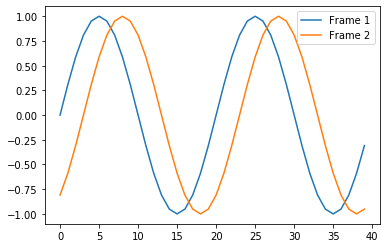

In [23]:
# Generate the two frames
width = 40
frequency = 2*np.pi/(width/2)
displacement = 3

frame1 = np.sin(np.arange(width) * frequency)
frame2 = np.sin((np.arange(width)-displacement) * frequency)

plt.figure()
plt.plot(frame1, label="Frame 1")
plt.plot(frame2, label="Frame 2")
plt.legend();

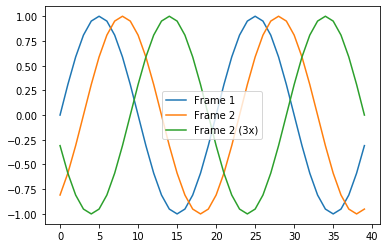

In [24]:
# Compute DFT of the frames
frame1_dft = scipy.fftpack.fft(frame1)
frame2_dft = scipy.fftpack.fft(frame2)

# Get window of frequencies to keep (filter)
# Here we only use one filter that keeps the entire negative frequency band, because the motion is global (and the picture is an aligned sinusoid)
window = np.argwhere(scipy.fftpack.fftfreq(width) < 0).flatten()

magnified_dft = np.array(frame2_dft, copy=True)
magnification_factor = 2

def part_of_magnification_routine(frame1_dft,frame2_dft,window,magnification_factor,magnified_dft):

    # Filter
    filtered1_dft = np.zeros(width, dtype=np.complex)
    filtered1_dft[window] = frame1_dft[window]
    filtered2_dft = np.zeros(width, dtype=np.complex)
    filtered2_dft[window] = frame2_dft[window]

    # Inverse transform back to time-domain
    filtered1 = scipy.fftpack.ifft(filtered1_dft)
    filtered2 = scipy.fftpack.ifft(filtered2_dft)

    # Compute phase difference
    phase_diff = np.angle(filtered2) - np.angle(filtered1)

    # Magnify motion in frame 2
    magnified_filtered = filtered2 * np.exp(magnification_factor*np.complex(0,1)*phase_diff)

    # Inverse filter in frequency domain
    magnified_filtered_dft = scipy.fftpack.fft(magnified_filtered)

    reflect_f = np.vectorize(lambda i : -i % width if ( width%2==1 or (width%2==0 and i%width!=width//2) ) else i % width)
    magnified_dft[reflect_f(window)] = np.conjugate(magnified_filtered_dft[window])
    magnified_dft[window] = magnified_filtered_dft[window]

part_of_magnification_routine(frame1_dft,frame2_dft,window,magnification_factor,magnified_dft)

# Get magnified frame
magnified = scipy.fftpack.ifft(magnified_dft)

plt.figure()
plt.plot(frame1, label="Frame 1")
plt.plot(frame2, label="Frame 2")
plt.plot(magnified, label="Frame 2 (%dx)" %(magnification_factor+1))
plt.legend();

## Example 2

Frame 1: two boxes; frame 2: boxes moved away from each other.  Motion-magnified frame 2 should see a greater separation of the boxes.

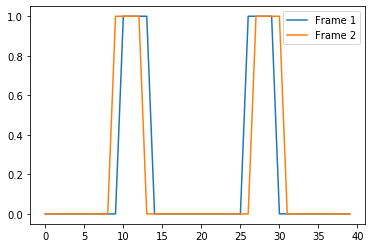

In [25]:
# Generate the two frames
width = 40
box_size = 4
box_sep = 7
displacement = 1

def osc_rects(t,sep=3,disp=2,width=3,length=23):
    offset = lambda t: t%disp if (t%(disp*2))/disp < 1 else disp - t%disp
    x = np.zeros((t,length),dtype=np.float32)
    for i in range(t):
        r1 = length//2 - sep - offset(i); l1 = r1 - width + 1
        x[i,l1:r1+1] = x[i,length-r1-1:length-l1] = 1
    return x

frame1, frame2 = osc_rects(displacement+1,box_sep,displacement,box_size,width)[[0,-1]]

plt.figure()
plt.plot(frame1, label="Frame 1")
plt.plot(frame2, label="Frame 2")
plt.legend();

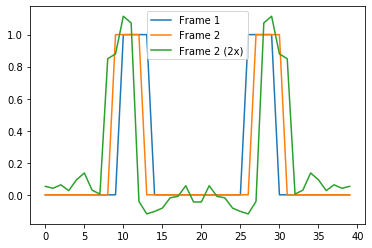

In [27]:
# Compute DFT of the frames
frame1_dft = scipy.fftpack.fft(frame1)
frame2_dft = scipy.fftpack.fft(frame2)

# Get window of frequencies to keep (filter)
# Here we use partition the negative frequencies into 4 octaves and perform processing on each band
num_octaves = 4
freq_range = np.argwhere(scipy.fftpack.fftfreq(width) < 0).flatten()
partitions = np.floor(len(freq_range)*np.power(2,np.arange(num_octaves-1))/2**(num_octaves-1)).astype(np.int32)
windows = np.array_split(freq_range,partitions)

magnified_dft = np.array(frame2_dft, copy=True)
magnification_factor = 1

for window in windows:
    part_of_magnification_routine(frame1_dft,frame2_dft,window,magnification_factor,magnified_dft)

# Get magnified frame
magnified = scipy.fftpack.ifft(magnified_dft)

plt.figure()
plt.plot(frame1, label="Frame 1")
plt.plot(frame2, label="Frame 2")
plt.plot(magnified, label="Frame 2 (%dx)" %(magnification_factor+1))
plt.legend();

### Bad Box Example

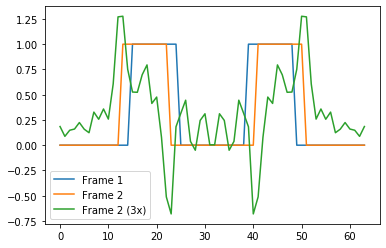

In [43]:
width = 64
box_size = 10
box_sep = 8
displacement = 2
num_octaves = 4
magnification_factor = 2

frame1, frame2 = osc_rects(displacement+1,box_sep,displacement,box_size,width)[[0,-1]]

frame1_dft = scipy.fftpack.fft(frame1)
frame2_dft = scipy.fftpack.fft(frame2)

freq_range = np.argwhere(scipy.fftpack.fftfreq(width) < 0).flatten()
partitions = np.floor(len(freq_range)*np.power(2,np.arange(num_octaves-1))/2**(num_octaves-1)).astype(np.int32)
windows = np.array_split(freq_range,partitions)

magnified_dft = np.array(frame2_dft, copy=True)
for window in windows:
    part_of_magnification_routine(frame1_dft,frame2_dft,window,magnification_factor,magnified_dft)

magnified = scipy.fftpack.ifft(magnified_dft)

plt.figure()
plt.plot(frame1, label="Frame 1")
plt.plot(frame2, label="Frame 2")
plt.plot(magnified, label="Frame 2 (%dx)" %(magnification_factor+1))
plt.legend();